# Cheers! What can wine review data tell us about price and quality?

#### Lizzy Knippler
BIOS 512

In [2]:
library(tidyverse, quietly = TRUE)
library(ggrepel, quietly = TRUE)
library(tidyr, quietly = TRUE)
library(ggrepel, quietly = TRUE)

## Data source and description

This dataset comes from a [Tidy Tuesday project](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-05-28) and is a *Wine Enthusiast* ratings dataset from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews). The original dataset is quite large, containing data from 129,971 reviews of wine. For this analysis, cases are dropped if there are incomplete data for the following variables: country, price, or points. Further subsets of the data are used throughout the analysis; for instance, the datset is restricted to the top 10 varieties, making it a bit more managable, limited to only 67,211 entries.


In [3]:
df_raw = read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-05-28/winemag-data-130k-v2.csv")

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  country = col_character(),
  description = col_character(),
  designation = col_character(),
  points = col_double(),
  price = col_double(),
  province = col_character(),
  region_1 = col_character(),
  region_2 = col_character(),
  taster_name = col_character(),
  taster_twitter_handle = col_character(),
  title = col_character(),
  variety = col_character(),
  winery = col_character()
)



In [5]:
df_raw %>% count

n
<int>
129971


In [6]:
df_wine = df_raw %>% drop_na(country, price, points)

In [7]:
df_wine %>%
    group_by(variety) %>%
    summarize(N = n()) %>%
    arrange(desc(N)) %>%
    head(10)

`summarise()` ungrouping output (override with `.groups` argument)



variety,N
<chr>,<int>
Pinot Noir,12785
Chardonnay,11077
Cabernet Sauvignon,9384
Red Blend,8466
Bordeaux-style Red Blend,5340
Riesling,4971
Sauvignon Blanc,4780
Syrah,4086
Rosé,3261


In [8]:
df_top10 = df_wine %>%
    filter(variety %in% c('Pinot Noir','Chardonnay','Cabernet Sauvignon','Red Blend',
                          'Bordeaux-style Red Blend','Riesling','Sauvignon Blanc','Syrah',
                          'Rosé','Merlot'))
df_top10 %>% count()

n
<int>
67211


In [9]:
df_top10 %>%
    group_by(country) %>%
    summarize(N = n()) %>%
    arrange(desc(N)) %>%
    head(5)

`summarise()` ungrouping output (override with `.groups` argument)



country,N
<chr>,<int>
US,39006
France,10729
Italy,4089
Chile,3339
Germany,1833


## What wines are getting reviewed? Who makes them?

In this dataset, the top 10 wine varieties are Pinot Noir, Chardonnay, Cabernet Sauvignon, Red Blend, Bordeaux-style Red Blend, Riesling, Sauvignon Blanc, Syrah, Rosé, and Merlot. The rest of the analyses are limited to these top 10 (most commonly reviewed) wine varieties.

The top five countries producing these wines are:
    1. United States
    2. France
    3. Italy
    4. Chile
    5. Germany
    
As seen in the bar chart below, while overall the United States is the dominant producer of wines in this dataset, the distribution of producers varies depending on type. For instance, France produces the most Bordeux-style red blends and rosé wines in this dataset, Italy comes through with the most red blends, and Germany shines with its Rieslings.

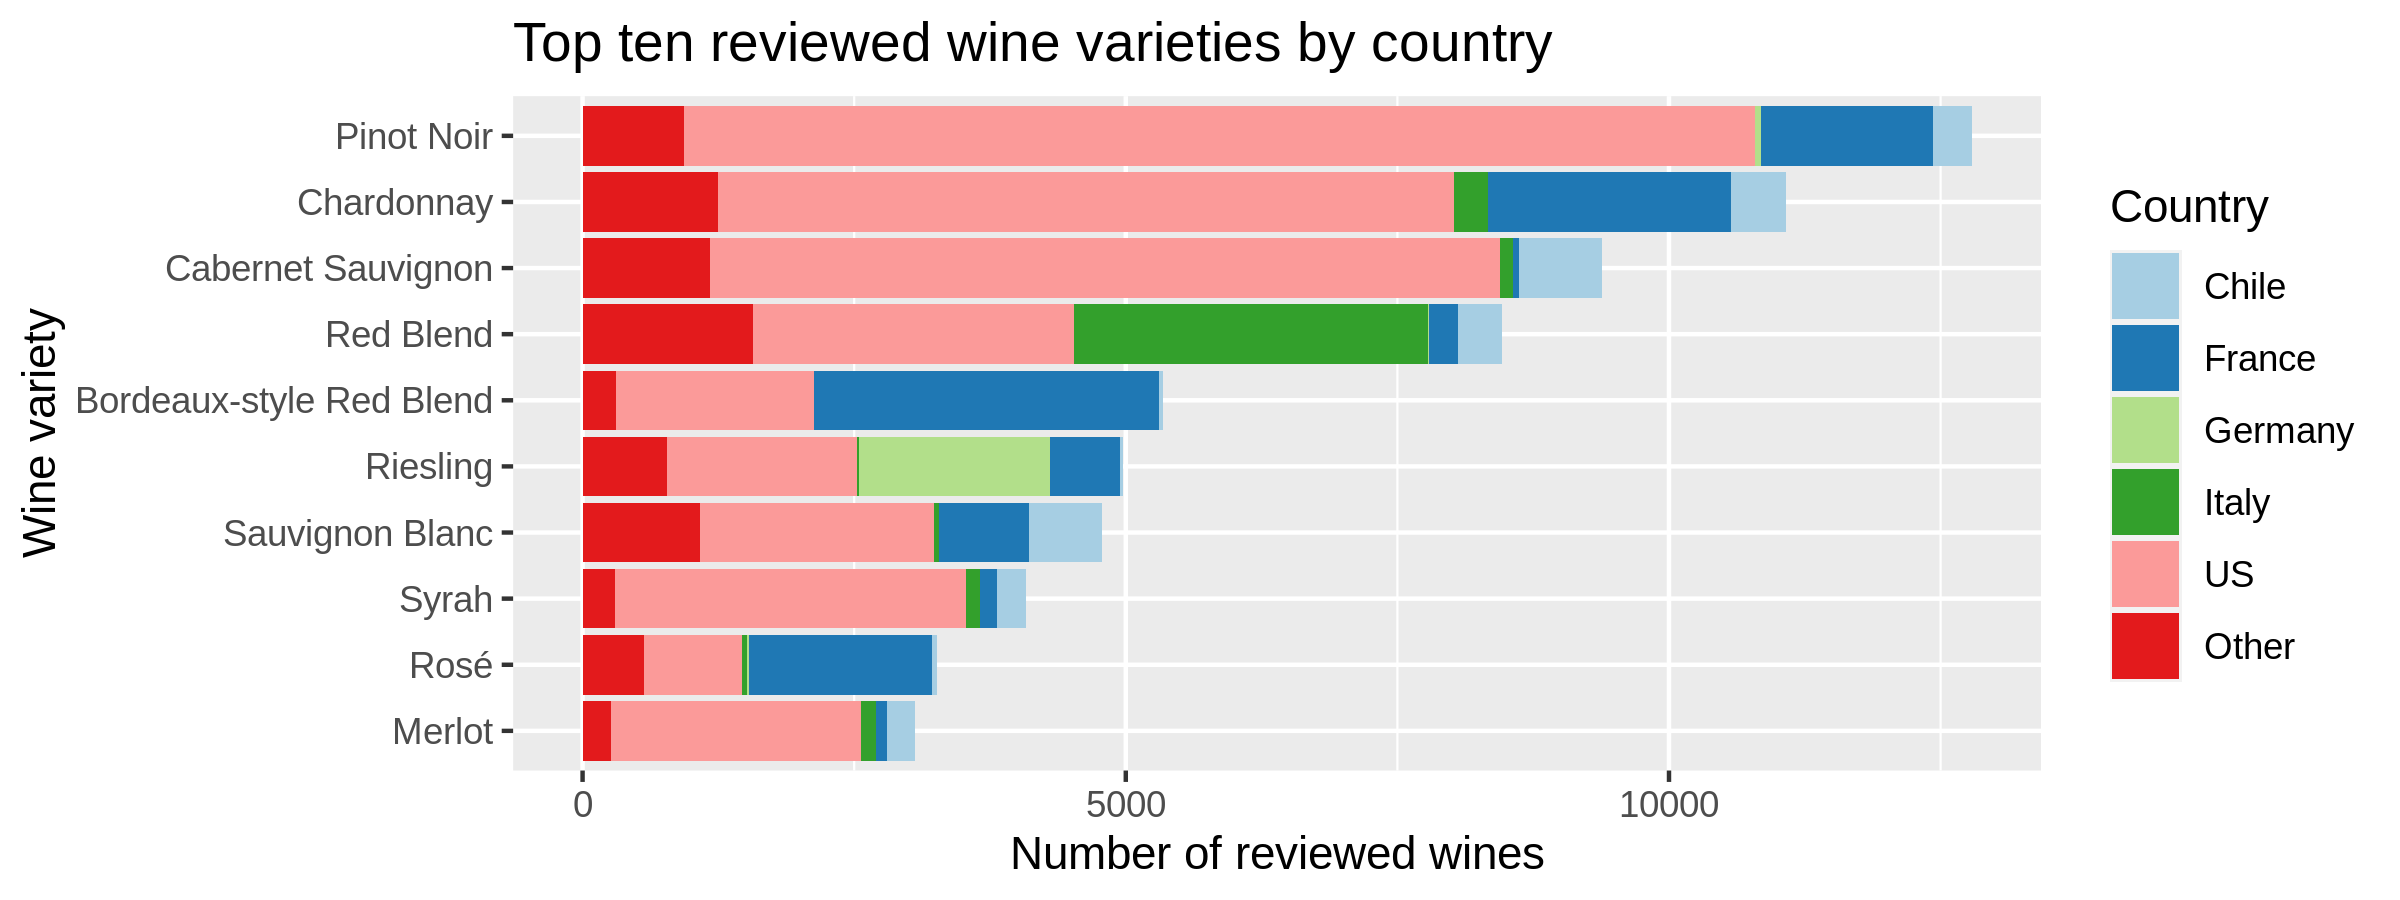

In [10]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res = 300)
df_lumped = df_top10 %>%
    mutate(country_lumped = country %>% fct_lump(n = 5)) 
p = ggplot(df_lumped, aes(y=variety %>% fct_infreq() %>% fct_rev(), fill = country_lumped))
p = p + geom_bar()
p = p + labs(y = 'Wine variety', x = 'Number of reviewed wines', title = 'Top ten reviewed wine varieties by country', fill = 'Country')
p  = p + scale_fill_brewer(palette = "Paired")
p

## What are these ratings all about?

Reviewers assign ratings to wines based on the [following scale](https://www.winemag.com/2010/04/09/you-asked-how-is-a-wines-score-determined/) from *Wine Enthusiast* magazine:

> **Classic 98-100**: The pinnacle of quality.  
> **Superb 94-97**: A great achievement.  
> **Excellent 90-93**: Highly recommended.  
> **Very Good 87-89**: Often good value; well recommended.  
> **Good 83-86**: Suitable for everyday consumption; often good value.  
> **Acceptable 80-82**: Can be employed in casual, less-critical circumstances.  
> *Wines receiving a rating below 80 are not reviewed.*

As seen below, most of the wines reviewed fall in the 85-95 point range, with just a few wines at the "pinnacle of quality."

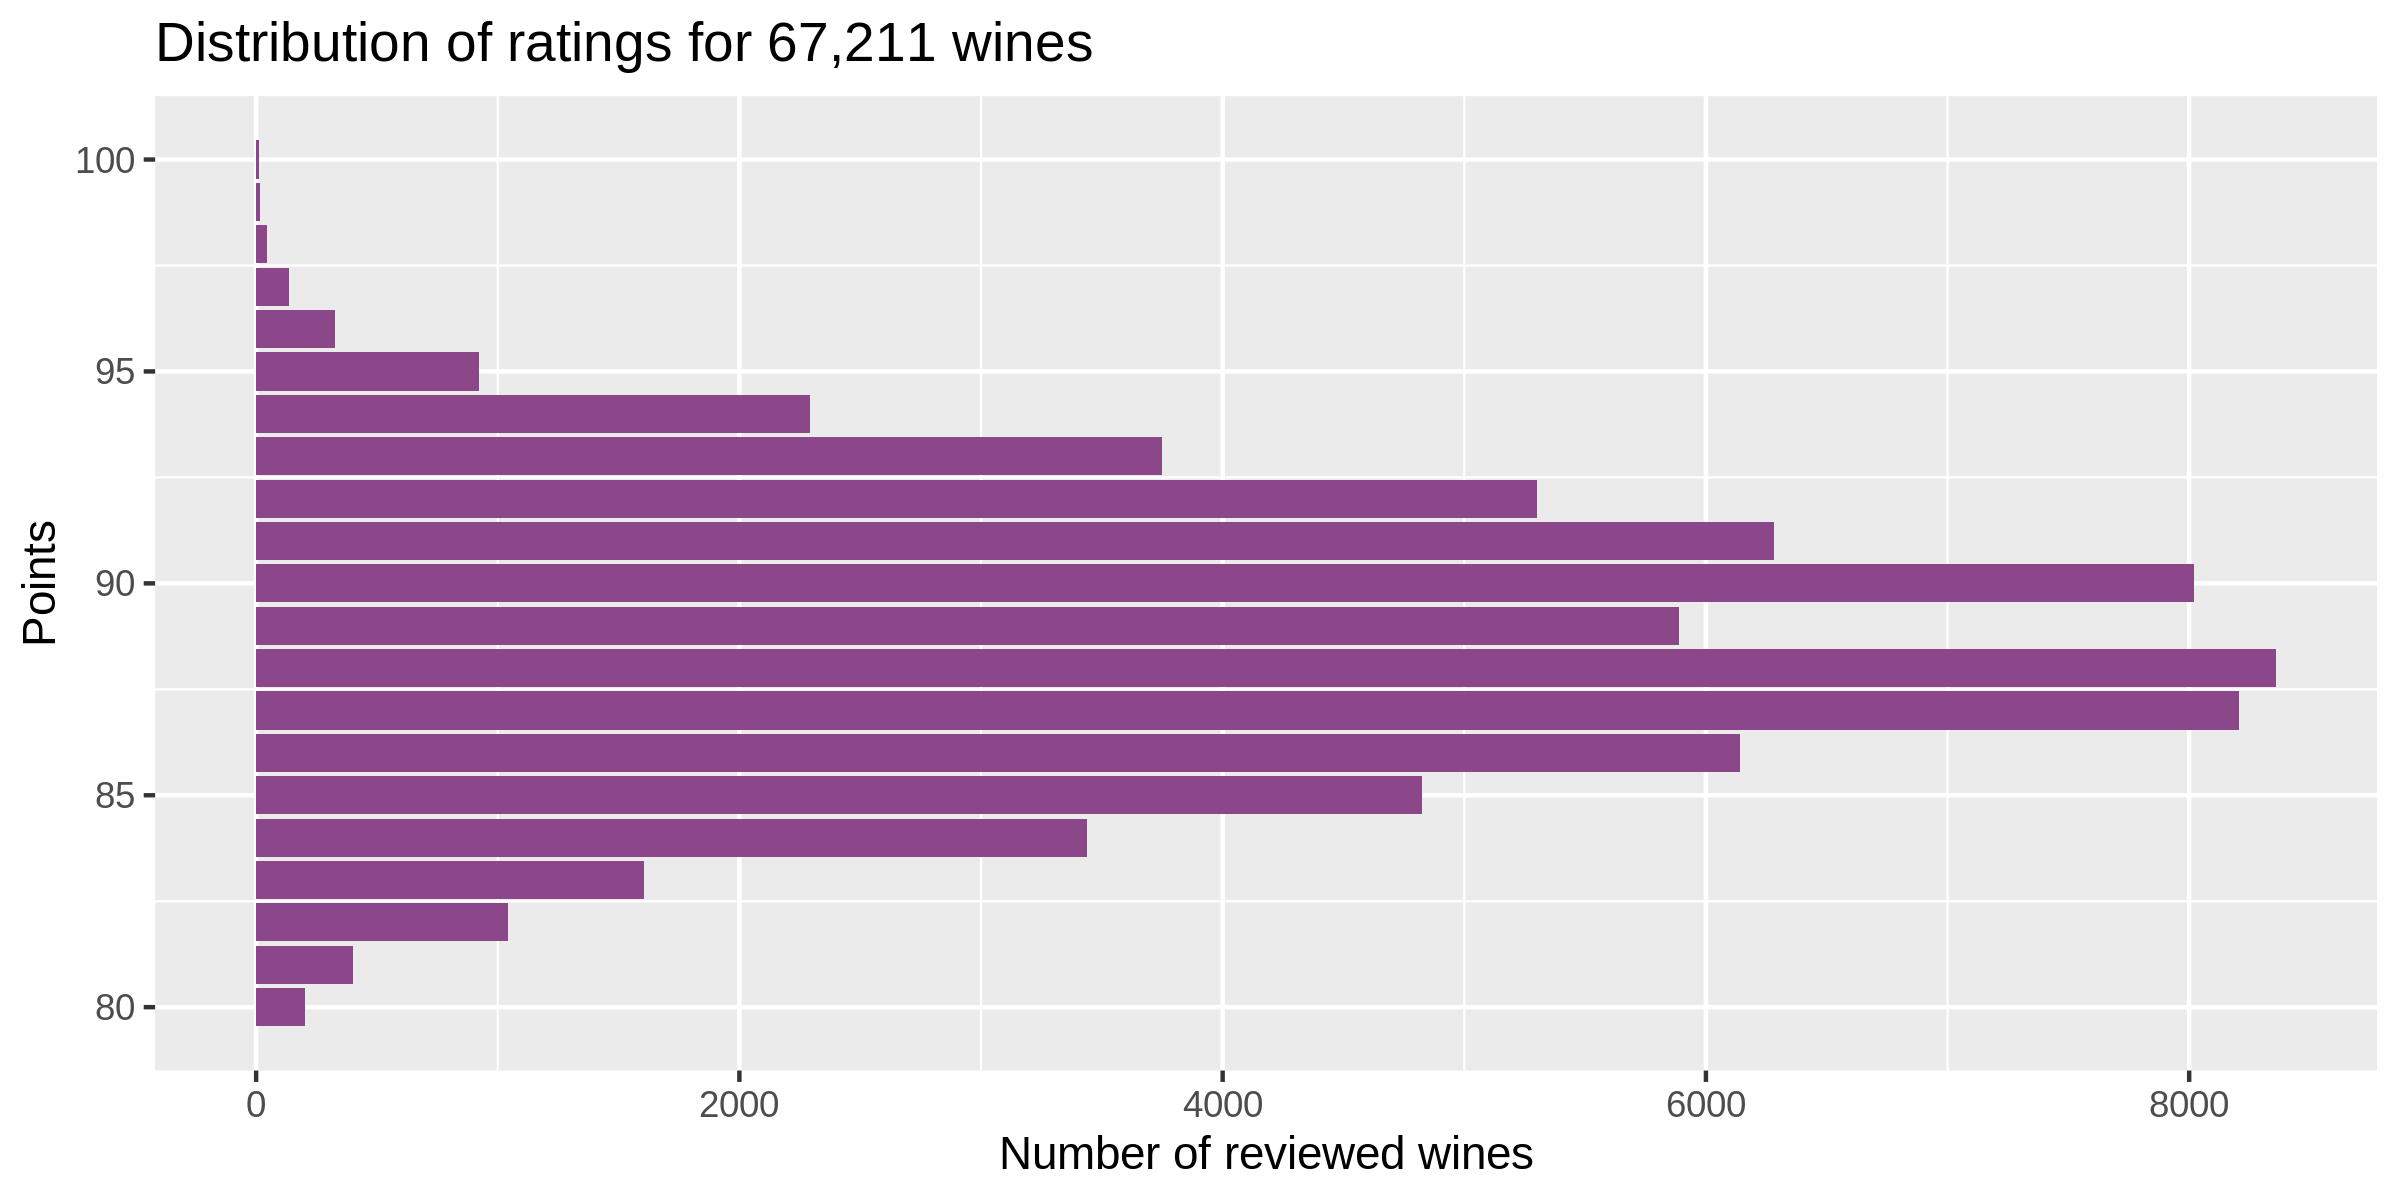

In [11]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 300)
p = ggplot(df_top10, aes(y=points))
p = p + geom_bar(fill = 'orchid4')
p = p + labs(y = 'Points', x = 'Number of reviewed wines', title = 'Distribution of ratings for 67,211 wines')
p

In [12]:
df_hist = df_top10
attach(df_hist)
df_hist$pts_cat[points<83] <- "Acceptable"
df_hist$pts_cat[points>=83 & points<87] <- "Good"
df_hist$pts_cat[points>=87 & points<90] <- "Very Good"
df_hist$pts_cat[points>=90 & points<94] <- "Excellent"
df_hist$pts_cat[points>=94 & points<98] <- "Superb"
df_hist$pts_cat[points>=98 & points<101] <- "Classic"
detach(df_hist)

Warning message:
“Unknown or uninitialised column: `pts_cat`.”


## So how pricey are these wines?

The reviewed wines range in price from 4 dollars to 3,300 dollars, so there are options for every budget. As may be expected, the higher-scoring wines tend to be priced higher than the lower-scoring wines, although there are certainly exceptions. One might ask, what is so special about that $3,300 bottle of wine, when by one reviewer's standards it is merely a "good" wine (hardly a "good value")?! (*For those curious, it is a Château les Ormes Sorbet 2013 Médoc.*)

But in general, if you're looking for the best wines, you'll probably have to pay more. The second plot below zooms in to wines priced under $500 and shows the distribution of prices by ranking category. Moving up in quality, the median price increases, although the lower price range of the distribution stays under 50 dollars for all categories.

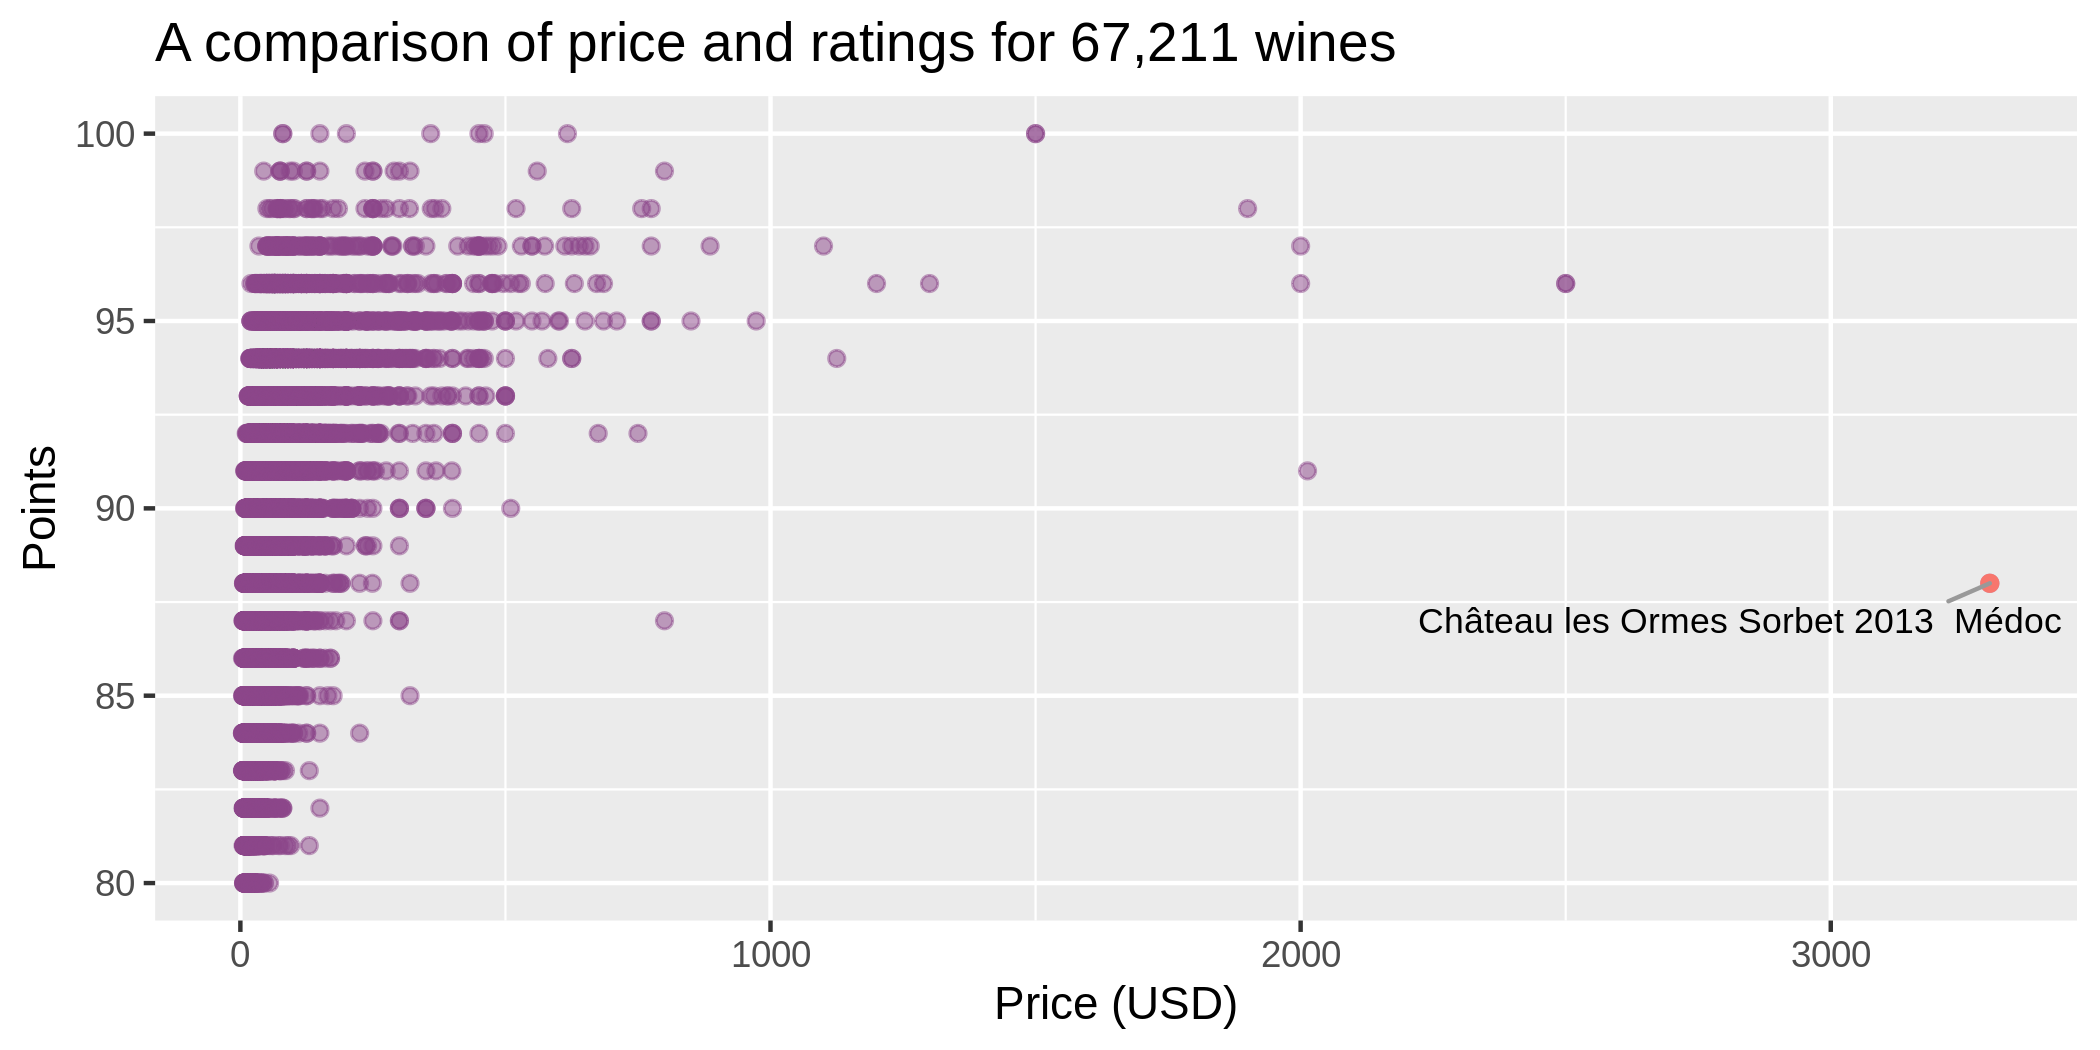

In [13]:
options(repr.plot.width=7, repr.plot.height=3.5, repr.plot.res = 300)
expensive = df_top10 %>% filter(price>3000)
p = ggplot(df_top10, aes(x = price, y = points))
p = p + geom_point(alpha = 0.5, color = 'orchid4')
p = p + labs(x = 'Price (USD)', y = 'Points', title = 'A comparison of price and ratings for 67,211 wines')
p = p + geom_point(data=expensive, aes(color='red'))
p = p + geom_text_repel(nudge_y = -1, nudge_x = -0.5, segment.color = "gray60", data = expensive, aes(label = title), size = 3)
p = p + theme(legend.position = "none")
p

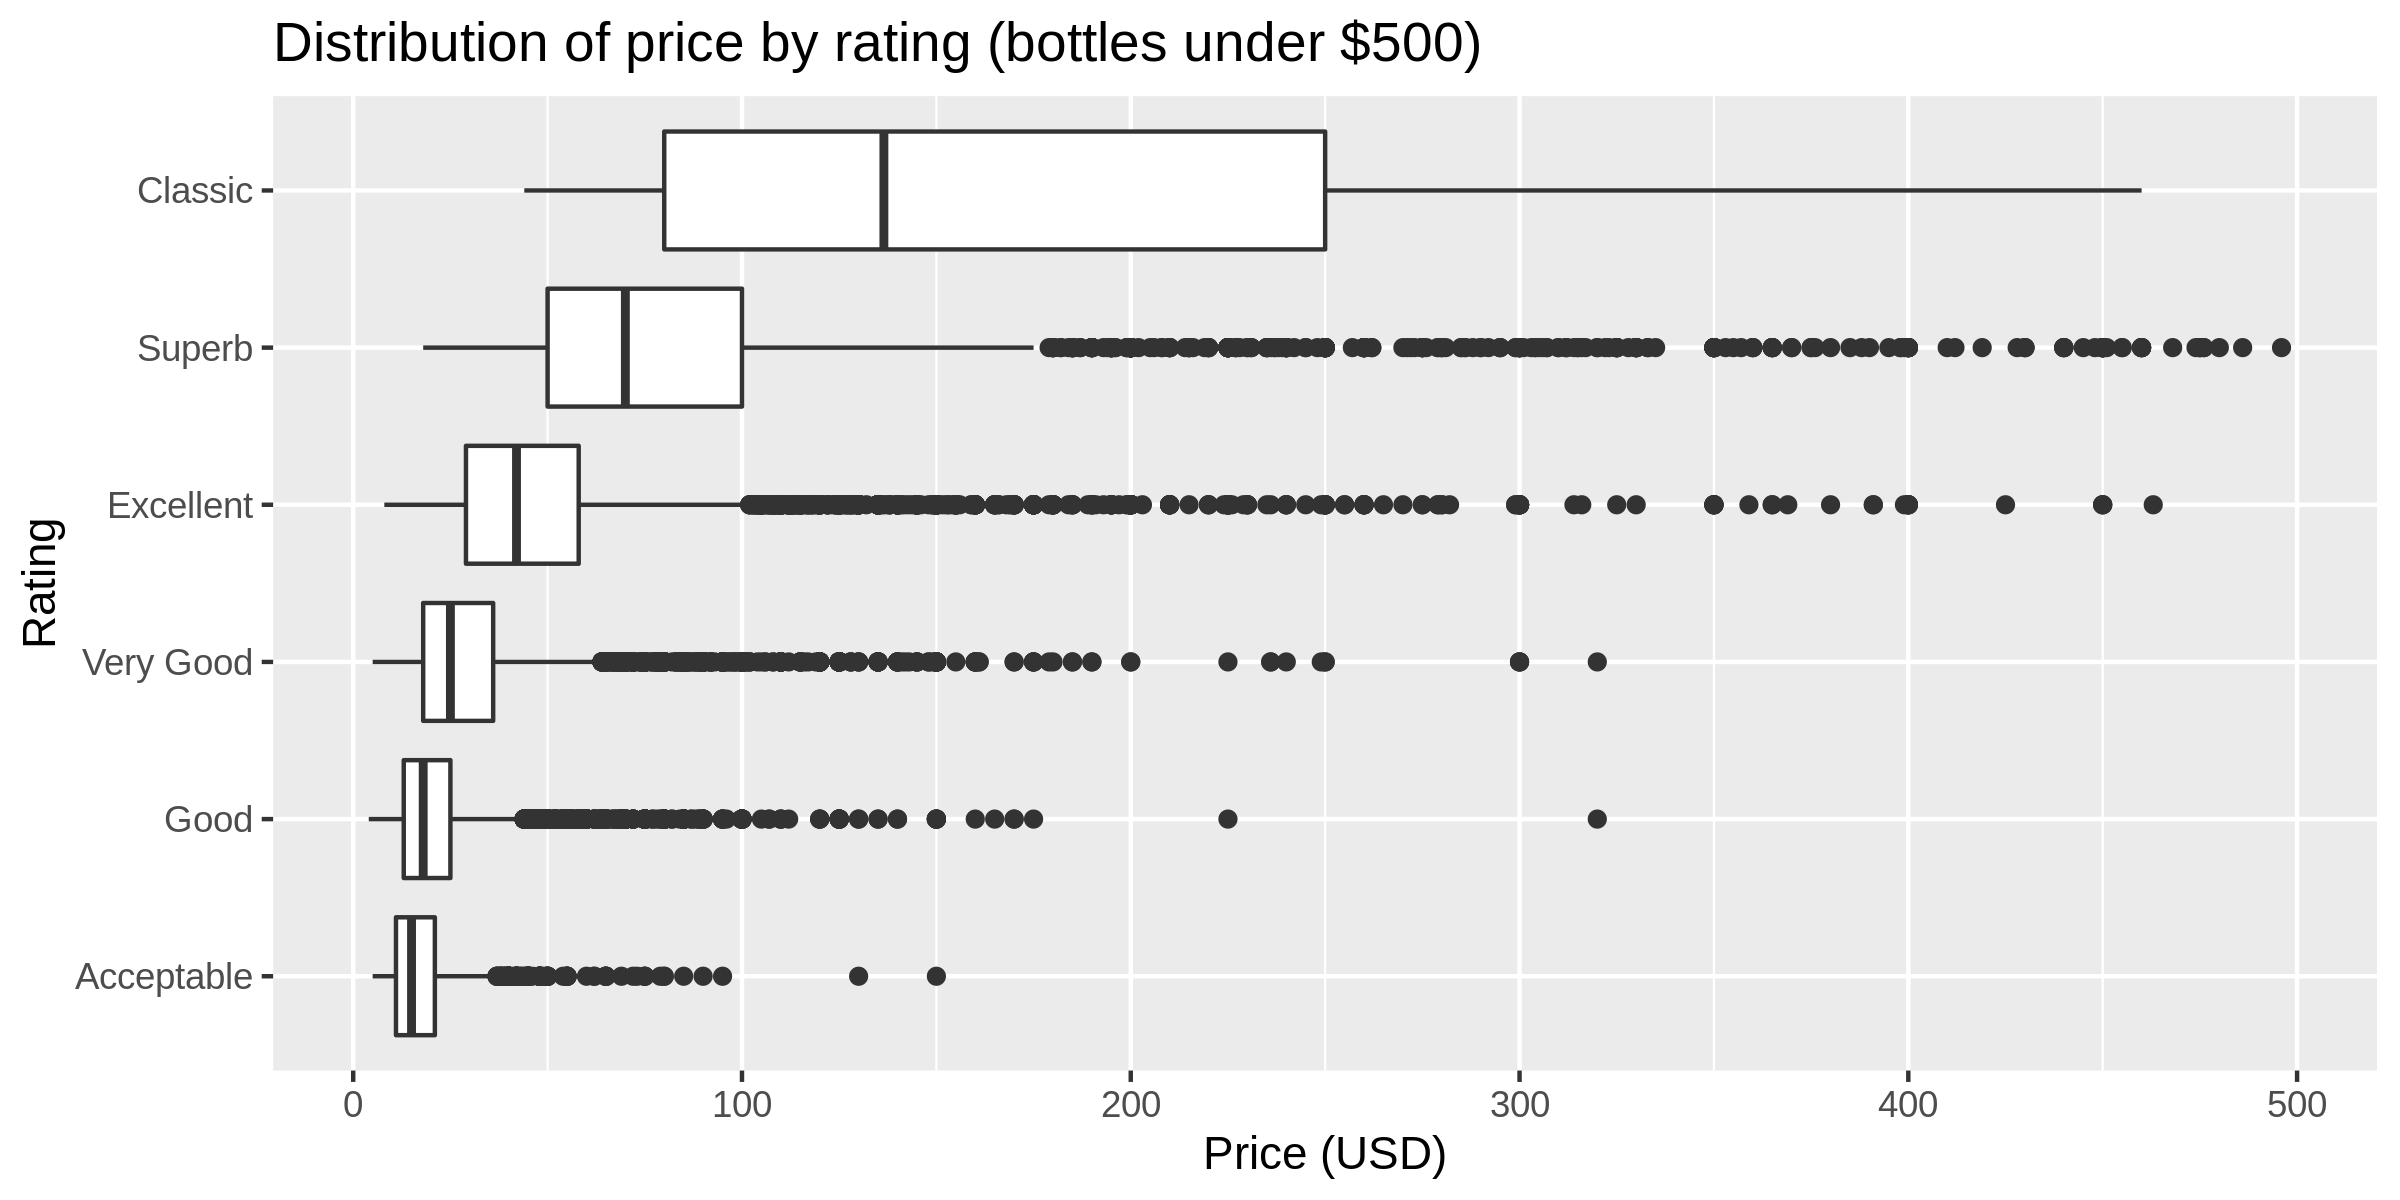

In [14]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 300)
p = ggplot(df_hist %>% filter(price<500), aes(x = pts_cat %>% fct_reorder(points, median), y = price))
p = p + geom_boxplot()
p = p + coord_flip()
p = p + labs(y = 'Price (USD)', x = 'Rating', title = 'Distribution of price by rating (bottles under $500)')
p

In [15]:
df_top10 %>%
    summarize(min_price = min(price), max_price = max(price))

min_price,max_price
<dbl>,<dbl>
4,3300


## What types of wine are best? Most expensive? Who makes them?

The series of graphs below show the price, ratings, and producing country for bottles of wine less than 500 dollars. Overall, wines made in the U.S. tend to be on the lower end of the price range, while the more expensive bottles of wine come largely from France, Italy, and Germany. The price and score ranges also appear to be dependent on the variety of wine. For example, there appear to be few (if any) Rosé or Sauvignon Blanc wines scoring in the *Superb* or *Classic* ranges, but you also won't be dropping more than $150 on a single bottle.If you're interested in Merlots, spending a little extra on a bottle from Italy may get you a higher quality. Pinot Noirs from France or Germany appear to be more expensive, but not necessarily better quality than their counterparts from other countries.

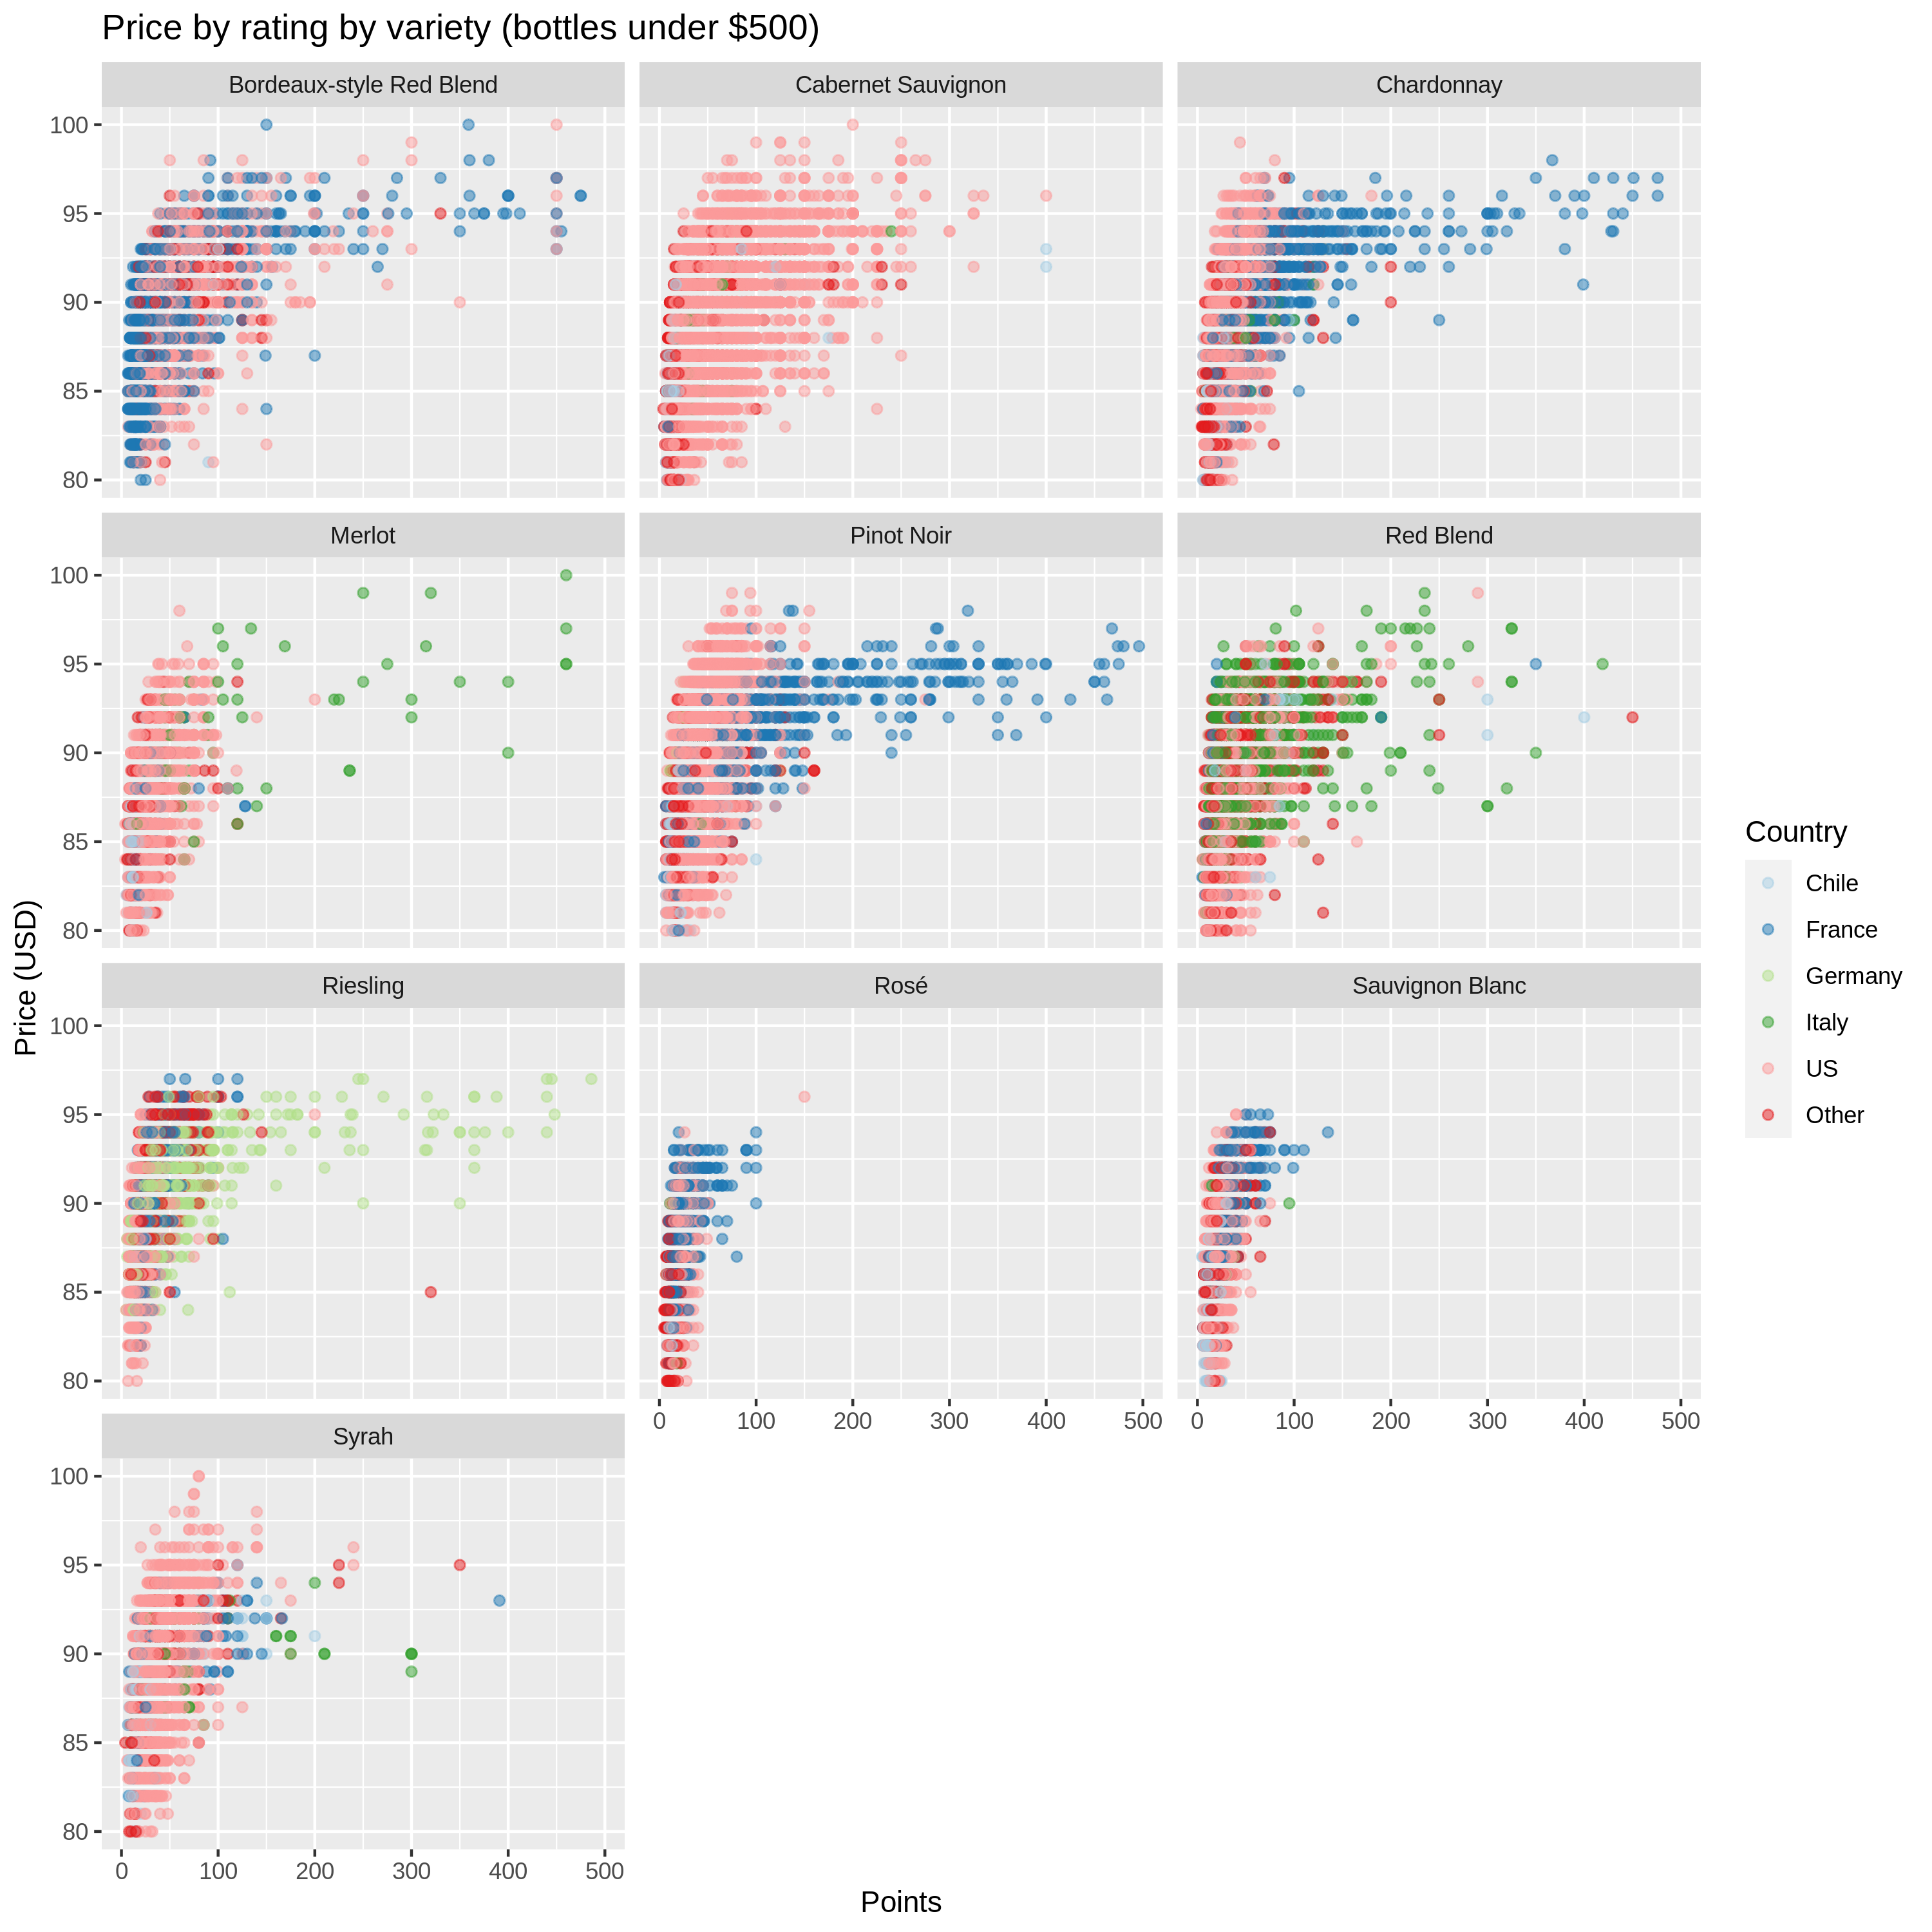

In [16]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)
p = ggplot(df_lumped %>% filter(price<500), aes(x = price, y = points, color = country_lumped))
p = p + geom_point(alpha = 0.5)
p = p + facet_wrap(~variety, ncol=3)
p = p + scale_color_brewer(palette = "Paired")
p = p + labs(y = 'Price (USD)', x = 'Points', title = 'Price by rating by variety (bottles under $500)', color = 'Country')
p

In [17]:
df_colors = df_top10
attach(df_colors)
df_colors$wine_color[variety %in% c('Pinot Noir','Cabernet Sauvignon','Red Blend',
                          'Bordeaux-style Red Blend','Syrah','Merlot')] <- "Red"
df_colors$wine_color[variety %in% c('Chardonnay','Riesling','Sauvignon Blanc')] <- "White"
df_colors$wine_color[variety=='Rosé'] <- "Rosé"
detach(df_colors)

Warning message:
“Unknown or uninitialised column: `wine_color`.”


## But what if I'm on a budget?!

There are still plenty of opetions of well-reviewed wines that might be in a lower price range - even a few in the *Excellent* range that are under 10 dollars! Regardless of if someone is looking for a red wine, a white wine, or a rosé, one can find an option that balances their desire for quality vs. the money they want to put out. While the cheapest bottles don't quite get into the highest levels of quality, buyers should note that just because they are spending more, doesn't mean they will get a better-rated wine. For instance, there appear to be many red wines that are above 40 dollars that still only fall in the *Acceptable* or *Good* ranges. If someone really wanted to get the best bang for their buck, they could search the Wine Enthusiast reviews for those special bottles achieving a high rating for a low price.

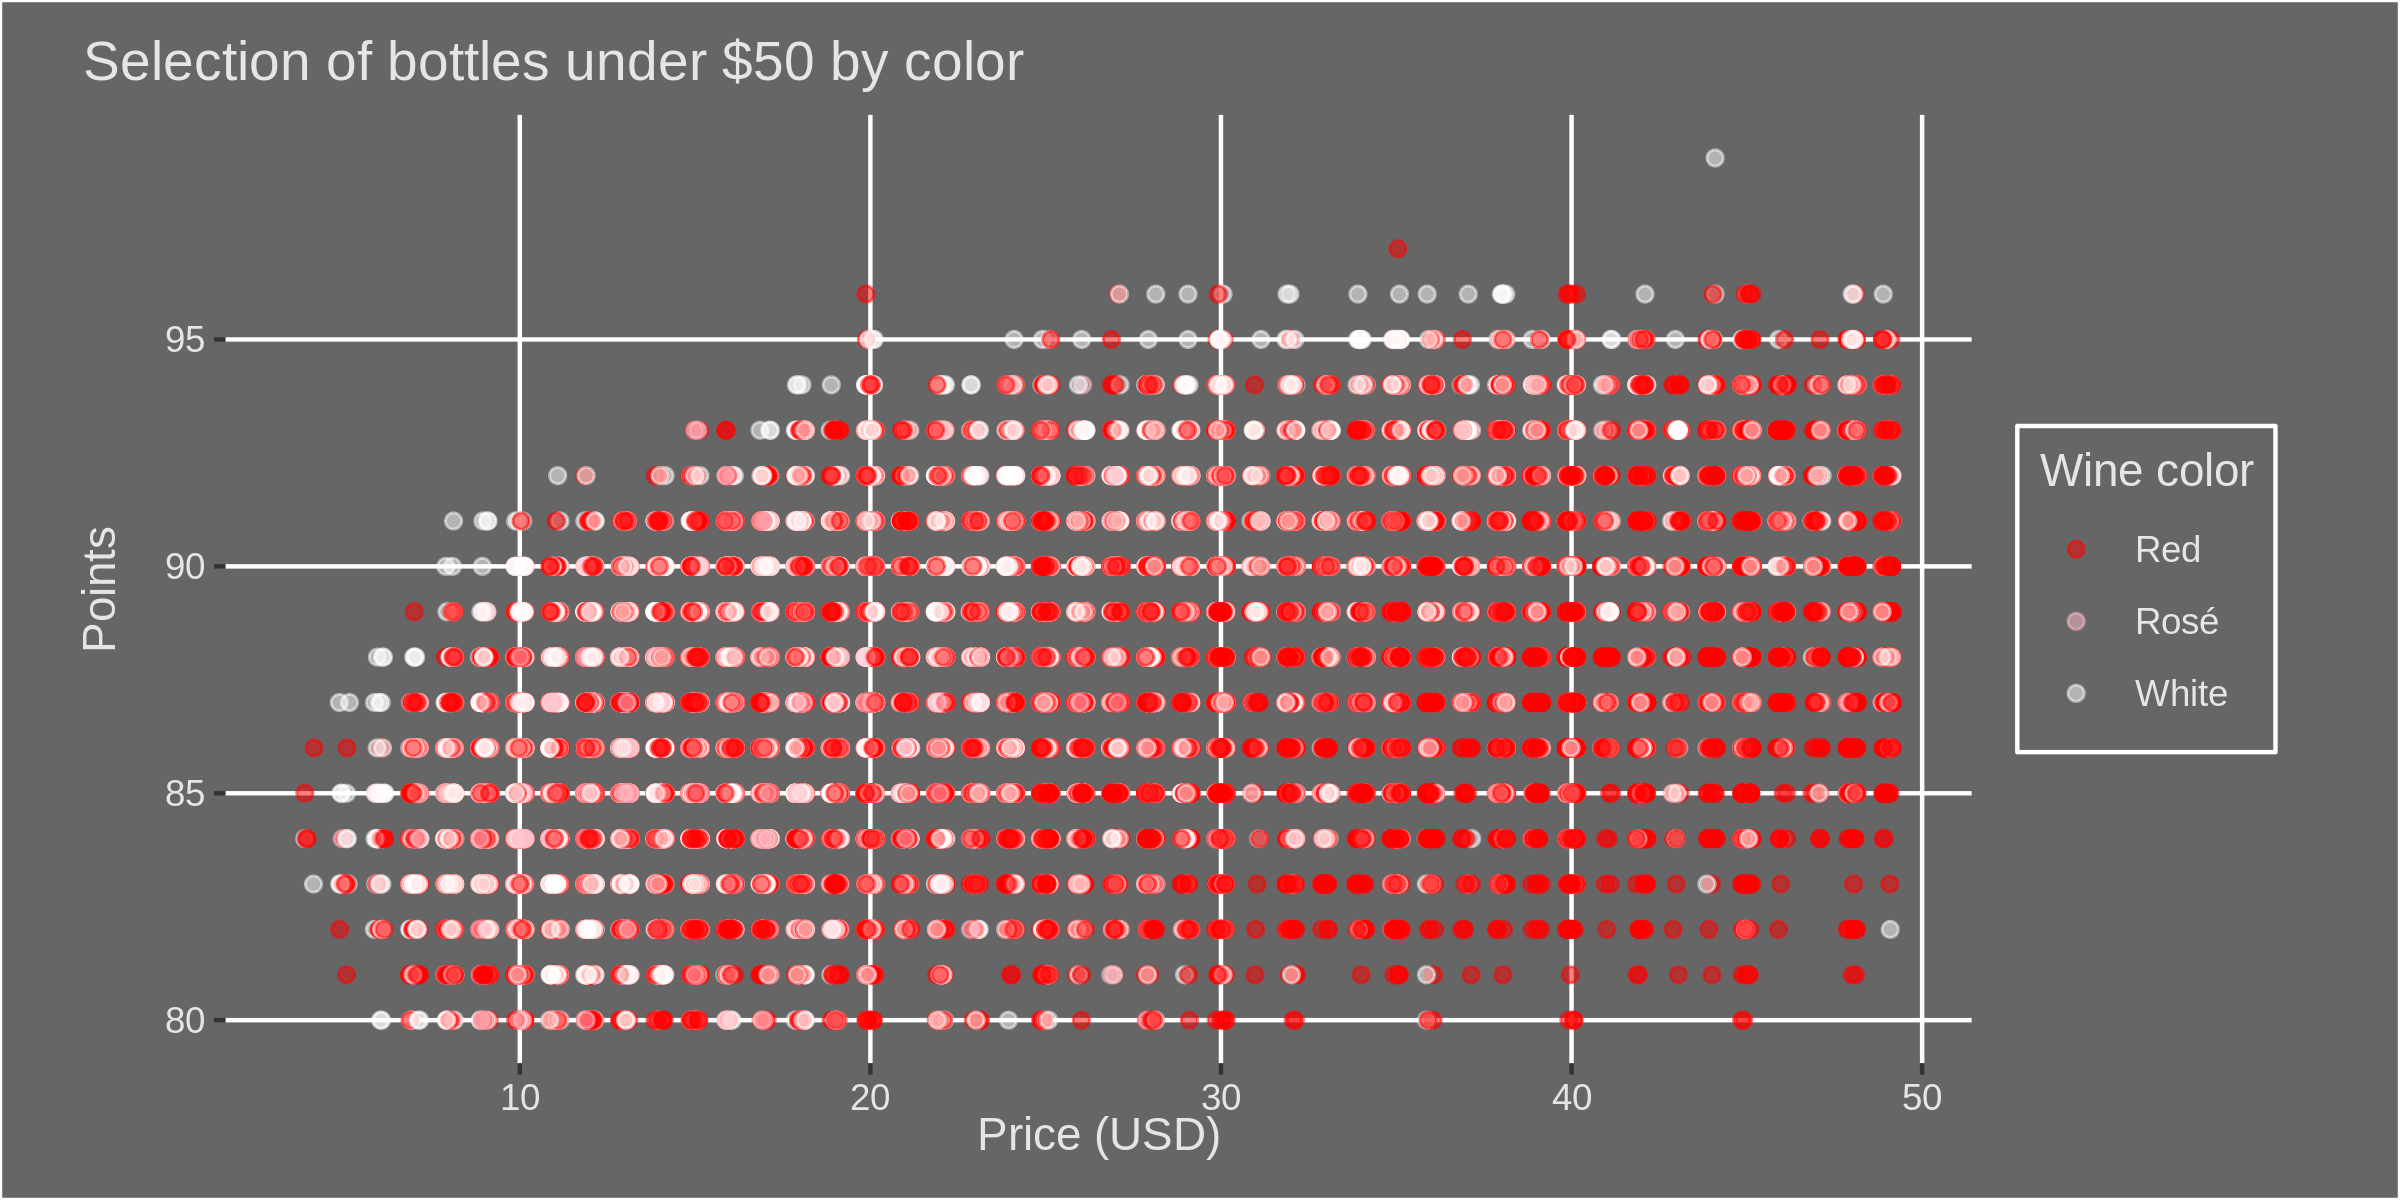

In [18]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 300)

p = ggplot(df_colors %>% filter(price<50), aes(x = price, y = points, color = wine_color))
p = p + geom_point(alpha = 0.5, position = position_jitter(h=0, w=0.15))
p = p + labs(x = 'Price (USD)', y = 'Points', color = 'Wine color', title = 'Selection of bottles under $50 by color')
p = p + scale_color_manual(breaks = c("Red", "Rosé", "White"), values=c("red", "pink", "white"))
p = p + theme(
           plot.background = element_rect(fill = 'gray40'), panel.background = element_rect(fill = 'gray40'),
              panel.grid.minor = element_line(color = 'transparent'), plot.margin = margin(10,30,10,20),
              plot.title.position = "plot", plot.title = element_text(color = 'gray90'),
              axis.title.y = element_text(margin = margin(0,10,0,0), color = 'gray90'),
              axis.title.x = element_text(margin = margin(0,10,0,0), color = 'gray90'),
              axis.text = element_text(colour = "gray90"),
              legend.key = element_rect(fill = "gray40"), legend.background = element_rect(fill = "gray40", color = 'white'),
            legend.title = element_text(color = 'gray90'), legend.text = element_text(color = "gray90"))
p

So whether you're looking for a fancy bottle to celebrate, a cheap bottle for every day, or simply wish to enjoy some cool data visualizations while sipping on grape juice... enjoy!